In [1]:
import pandas as pd
import numpy as np
import ast
from tabulate import tabulate
import json
import yaml
import matplotlib.pyplot as plt
import itertools


pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

In [2]:
df = pd.read_csv(r"../output/REALRUN.csv")

In [3]:
# List of metric names
metric_names = ["lift",
    "f1",
    "mse",
    "accuracy",
    "recall",
    "precision",
    "roc_auc",
    "area_under_pr",
    "r2_score",
    "rmse"
]
dataset = df.copy()
# Create columns based on metric names
# Convert string representations to dictionaries
dataset["output_metrics"] = dataset["output_metrics"].apply(ast.literal_eval)
dataset["run_time"] = dataset["run_time"].apply(lambda x: np.round(x/60, 2))
# Create columns based on metric names
for metric in metric_names:
    dataset[metric] = dataset["output_metrics"].apply(
        lambda x: x.get(metric) if isinstance(x, dict) else np.nan
    )
    dataset[f"{metric}_std"] = dataset[metric].apply(
        lambda x: np.std(x) if isinstance(x, list) else np.nan
    )
    dataset[metric] = dataset[metric].apply(
        lambda x: np.average(x) if isinstance(x, list) else np.nan
    )

base_cols   = [
    "dataset",
    "model",
    "run_time",
    "eval_metric",
    "best_score",
    "score_std",
    "output_metrics"]

base_cols += [i for i in metric_names]
base_cols += [i+"_std" for i in metric_names]

dataset = dataset[base_cols]

In [4]:
tomax = {
    "mse": False,
    "rmse": False,
    "accuracy": True,
    "recall": True,
    "precision": True,
    "roc_auc": True,
    "area_under_pr": True,
    "lift": True,
    "f1": True,
    "r2_score": True,
}

# Define a function to select the first row based on whether to maximize or minimize the "best_score"
def select_first_row(group):
    metric = group["eval_metric"].iloc[0]
    ascending = not tomax.get(metric, True)  # If metric not in tomax, assume True (maximize)
    return group.sort_values(by="best_score", ascending=ascending).iloc[0]


# Apply the function to each group
filtered_df = dataset.groupby(["dataset", "model", "eval_metric"]).apply(select_first_row)
# Reset the index to get a new DataFrame
filtered_df = filtered_df.reset_index(drop=True)
# Find the rows that maximize the specified metric for each dataset


# Sort the DataFrame based on whether the metric is to be maximized or not
filtered_df["ascending"] = filtered_df["eval_metric"].map({k:not v for k,v in tomax.items()})  # Create a new column for ascending order
dfmax = filtered_df.loc[filtered_df["ascending"] == False].sort_values(by=["dataset", "eval_metric", "best_score"], ascending=[False, False, False])
dfmin = filtered_df.loc[filtered_df["ascending"] == True].sort_values(by=["dataset", "eval_metric", "best_score"], ascending=[False, False, True])

best_df = pd.concat([dfmax,dfmin])
best_df.drop(columns=["ascending"], inplace=True)

best_df.head(100)

,dataset,model,run_time,eval_metric,best_score,score_std,output_metrics,lift,f1,mse,accuracy,recall,precision,roc_auc,area_under_pr,r2_score,rmse,lift_std,f1_std,mse_std,accuracy_std,recall_std,precision_std,roc_auc_std,area_under_pr_std,r2_score_std,rmse_std
27,housing,xgb,169.82,r2_score,0.860113,0.005730,"{'mse': [0.18389491614284115, 0.18921141804407...",NaN,NaN,0.186184,NaN,NaN,NaN,NaN,NaN,0.860113,0.431410,NaN,NaN,0.007102,NaN,NaN,NaN,NaN,NaN,0.005730,0.008305
16,housing,catboost,151.45,r2_score,0.857250,0.006923,"{'mse': [0.19250183836059037, 0.18818674812688...",NaN,NaN,0.189949,NaN,NaN,NaN,NaN,NaN,0.857250,0.435739,NaN,NaN,0.007751,NaN,NaN,NaN,NaN,NaN,0.006923,0.008984
21,housing,mlp,451.27,r2_score,0.810170,0.005604,"{'mse': [0.23528301311549074, 0.26627250618672...",NaN,NaN,0.252770,NaN,NaN,NaN,NaN,NaN,0.810170,0.502663,NaN,NaN,0.009968,NaN,NaN,NaN,NaN,NaN,0.005604,0.009975
24,housing,s1dcnn,264.27,r2_score,0.788397,0.005958,"{'mse': [0.27974722, 0.28572944, 0.26305422, 0...",NaN,NaN,0.281748,NaN,NaN,NaN,NaN,NaN,0.788397,0.530708,NaN,NaN,0.010362,NaN,NaN,NaN,NaN,NaN,0.005958,0.009839
23,housing,resnet,412.76,r2_score,0.780810,0.005440,"{'mse': [0.2877425600614717, 0.297002390263672...",NaN,NaN,0.291866,NaN,NaN,NaN,NaN,NaN,0.780810,0.540158,NaN,NaN,0.010590,NaN,NaN,NaN,NaN,NaN,0.005440,0.009805
15,housing,autoint,91.61,r2_score,0.739724,0.013623,"{'mse': [0.3651508267581246, 0.338813858130536...",NaN,NaN,0.346404,NaN,NaN,NaN,NaN,NaN,0.739724,0.588381,NaN,NaN,0.017170,NaN,NaN,NaN,NaN,NaN,0.013623,0.014546
19,housing,gandalf,133.31,r2_score,0.735546,0.016152,"{'mse': [0.3653180354969618, 0.362105160198984...",NaN,NaN,0.351999,NaN,NaN,NaN,NaN,NaN,0.735546,0.593013,NaN,NaN,0.021280,NaN,NaN,NaN,NaN,NaN,0.016152,0.018289
20,housing,gate,1459.37,r2_score,0.726947,0.016371,"{'mse': [0.37948690527021, 0.3829880265306214,...",NaN,NaN,0.363503,NaN,NaN,NaN,NaN,NaN,0.726947,0.602613,NaN,NaN,0.022536,NaN,NaN,NaN,NaN,NaN,0.016371,0.018995
17,housing,categoryembedding,83.20,r2_score,0.725487,0.013599,"{'mse': [0.38353388158082313, 0.37188981150896...",NaN,NaN,0.365345,NaN,NaN,NaN,NaN,NaN,0.725487,0.604274,NaN,NaN,0.016811,NaN,NaN,NaN,NaN,NaN,0.013599,0.014069
25,housing,tabnet,116.27,r2_score,0.721056,0.010754,"{'mse': [0.37525353407449663, 0.38438368160667...",NaN,NaN,0.371346,NaN,NaN,NaN,NaN,NaN,0.721056,0.609247,NaN,NaN,0.015465,NaN,NaN,NaN,NaN,NaN,0.010754,0.012804


# Check State of Run

In [5]:
with open("../configuration/experiment_config.yml", "r") as f:
    config = yaml.safe_load(f)

# Extract the necessary information from the configuration file
included_models = [i.lower() for i in config["include_models"]]
included_datasets = [i.lower() for i in config["include_datasets"]]

# Get all combinations of items from the two lists
combinations_possible = list(itertools.product(included_datasets, included_models))


# Get unique combinations based on 'Column1' and 'Column2'
existing_combinations = df[['dataset','model']].drop_duplicates()
# Convert the DataFrame to a list of tuples
existing_combinations = [tuple(row) for row in existing_combinations.values]

missing_combos = [i for i in combinations_possible if i not in existing_combinations]
for i in missing_combos:
    print(f"Missing Combination {i}")

Missing Combination ('iris', 'xgb')
Missing Combination ('iris', 'catboost')
Missing Combination ('iris', 'mlp')
Missing Combination ('iris', 'tabnet')
Missing Combination ('iris', 'gate')
Missing Combination ('iris', 'resnet')
Missing Combination ('iris', 's1dcnn')
Missing Combination ('iris', 'categoryembedding')
Missing Combination ('iris', 'fttransformer')
Missing Combination ('iris', 'tabtransformer')
Missing Combination ('iris', 'gandalf')
Missing Combination ('iris', 'autoint')
Missing Combination ('titanic', 'xgb')
Missing Combination ('titanic', 'catboost')
Missing Combination ('titanic', 'mlp')
Missing Combination ('titanic', 'tabnet')
Missing Combination ('titanic', 'gate')
Missing Combination ('titanic', 'resnet')
Missing Combination ('titanic', 's1dcnn')
Missing Combination ('titanic', 'categoryembedding')
Missing Combination ('titanic', 'fttransformer')
Missing Combination ('titanic', 'tabtransformer')
Missing Combination ('titanic', 'gandalf')
Missing Combination ('titan

In [10]:
[i for i in missing_combos if "catboost" in i]

[('iris', 'catboost'),
 ('titanic', 'catboost'),
 ('breastcancer', 'catboost'),
 ('ageconditions', 'catboost'),
 ('diabetes', 'catboost'),
 ('adult', 'catboost'),
 ('heloc', 'catboost'),
 ('covertype', 'catboost')]

In [11]:
[i for i in missing_combos if "xgb" in i]

[('iris', 'xgb'),
 ('titanic', 'xgb'),
 ('diabetes', 'xgb'),
 ('adult', 'xgb'),
 ('covertype', 'xgb')]

# Execution Time Visualization

In [12]:
best_df["dataset"].value_counts()

dataset
housing          13
creditcard       12
heloc             1
breastcancer      1
ageconditions     1
Name: count, dtype: int64

In [9]:
# Group by the "dataset" column and aggregate "run_time" using the sum function
hyperopt_evals = 100
num_parallel = 3
efficiency_estimate = 0.8
aggregated_df = best_df.groupby("model")["run_time"].sum().reset_index()
# Rename the aggregated column for clarity
aggregated_df = aggregated_df.rename(columns={"run_time": "sum_run_time"})
aggregated_df["total_search_hours_estimate"] = aggregated_df["sum_run_time"]*100/60/3*0.8
aggregated_df.sort_values("total_search_hours_estimate", ascending = False).head(20)

,model,sum_run_time,total_search_hours_estimate
5,gate,1526.32,678.364444
12,xgb,1128.07,501.364444
9,s1dcnn,868.37,385.942222
6,mlp,453.01,201.337778
8,resnet,436.57,194.031111
3,fttransformer,189.39,84.173333
4,gandalf,154.74,68.773333
1,catboost,152.34,67.706667
10,tabnet,127.19,56.528889
0,autoint,104.89,46.617778


# Housing


In [12]:
# Convert DataFrame to ASCII table
def make_results_table(df, dataset_name, display_cols, metric_cols, image_name, dpi = 1200):
    result_df = df.loc[df['dataset'] ==  dataset_name].reset_index(drop = True).copy()

    # Create a dictionary to store the indices of the rows with the highest values for each metric column
    max_indices = {}
    for metric in metric_cols:
        max_indices[metric] = result_df[metric].idxmax()
    
            
    # Modify all columns with std to include relative std
    result_df['best_score'] = result_df.apply(
            lambda row: f"{row['best_score']:.6f} ± ({row['score_std']:.6f})", axis=1
        )
    for metric in metric_cols:
        result_df[metric] = result_df.apply(
            lambda row: f"{row[metric]:.6f} ± ({row[metric+'_std']:.6f})", axis=1
        )
        # Drop the corresponding std column
        result_df.drop(columns=[metric + '_std'], inplace=True)


    # Apply underlining to the rows with the highest values for each metric column
    # for metric, max_index in max_indices.items():
        
        #result_df.at[max_index, metric] = '\033[1;4m' + result_df.at[max_index, metric] + '\033[0m'
    
    #print(result_df)
    
    ascii_table = tabulate(result_df[display_cols], headers='keys', tablefmt='fancy_grid')
    
    # Create a figure and axis for the plot
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Hide the axis
    ax.axis('off')
    
    # Display the ASCII table as text
    ax.text(0.1, 0.1, ascii_table, fontsize=10, family='monospace')
    
    # Save the plot as an image file (e.g., PNG)
    plt.savefig(f'./images/hyperopt/{image_name}.png', bbox_inches='tight', dpi=dpi, pad_inches=0.1)
    
    # Show the plot (optional)
    plt.show()
    return result_df[display_cols]

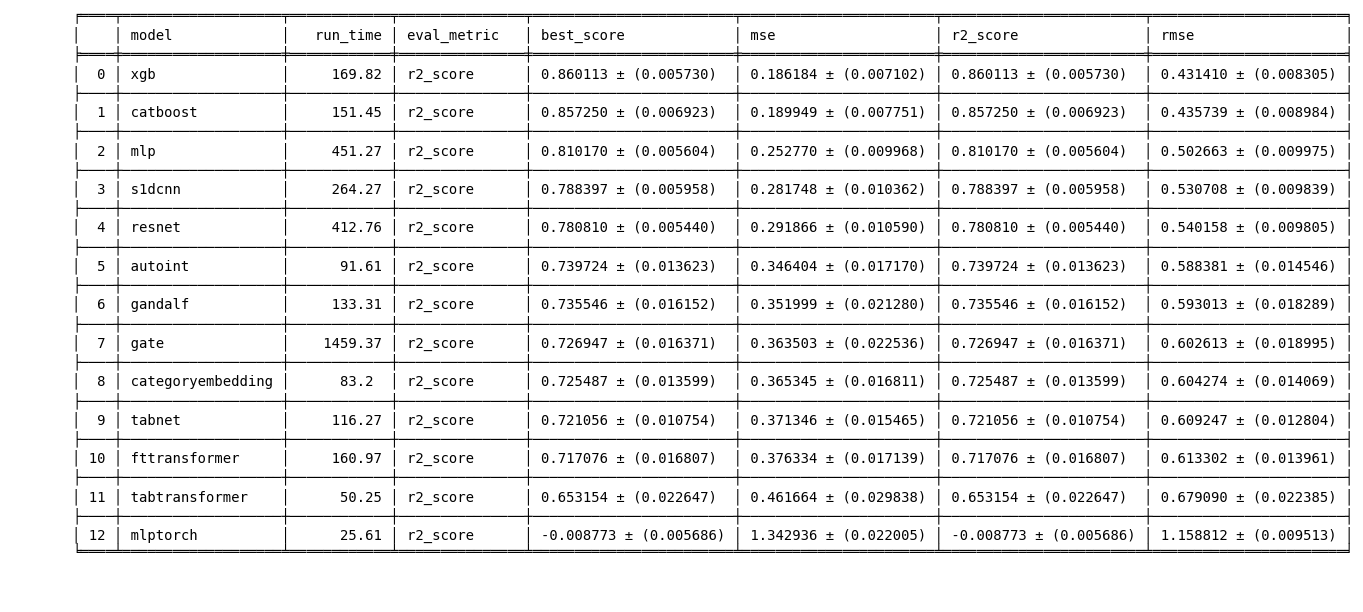

,model,run_time,eval_metric,best_score,mse,r2_score,rmse
0,xgb,169.82,r2_score,0.860113 ± (0.005730),0.186184 ± (0.007102),0.860113 ± (0.005730),0.431410 ± (0.008305)
1,catboost,151.45,r2_score,0.857250 ± (0.006923),0.189949 ± (0.007751),0.857250 ± (0.006923),0.435739 ± (0.008984)
2,mlp,451.27,r2_score,0.810170 ± (0.005604),0.252770 ± (0.009968),0.810170 ± (0.005604),0.502663 ± (0.009975)
3,s1dcnn,264.27,r2_score,0.788397 ± (0.005958),0.281748 ± (0.010362),0.788397 ± (0.005958),0.530708 ± (0.009839)
4,resnet,412.76,r2_score,0.780810 ± (0.005440),0.291866 ± (0.010590),0.780810 ± (0.005440),0.540158 ± (0.009805)
5,autoint,91.61,r2_score,0.739724 ± (0.013623),0.346404 ± (0.017170),0.739724 ± (0.013623),0.588381 ± (0.014546)
6,gandalf,133.31,r2_score,0.735546 ± (0.016152),0.351999 ± (0.021280),0.735546 ± (0.016152),0.593013 ± (0.018289)
7,gate,1459.37,r2_score,0.726947 ± (0.016371),0.363503 ± (0.022536),0.726947 ± (0.016371),0.602613 ± (0.018995)
8,categoryembedding,83.20,r2_score,0.725487 ± (0.013599),0.365345 ± (0.016811),0.725487 ± (0.013599),0.604274 ± (0.014069)
9,tabnet,116.27,r2_score,0.721056 ± (0.010754),0.371346 ± (0.015465),0.721056 ± (0.010754),0.609247 ± (0.012804)


In [13]:
display_cols = ['model', 'run_time', 'eval_metric', 'best_score', 'mse','r2_score','rmse']
metric_cols = ['mse','r2_score','rmse']
dataset_name = "housing"
make_results_table(best_df, dataset_name, display_cols, metric_cols, image_name = dataset_name, dpi = 1200)

In [10]:
display_cols = ['model', 'run_time', 'eval_metric', 'best_score', 'accuracy','roc_auc', 'lift', 
                'f1','recall', 'precision', 'area_under_pr']
metric_cols = ['accuracy','roc_auc', 'lift', 
                'f1','recall', 'precision', 'area_under_pr']
dataset_name = "heloc"
make_results_table(best_df, dataset_name, display_cols, metric_cols, image_name = dataset_name, dpi = 1200)

ValueError: attempt to get argmax of an empty sequence

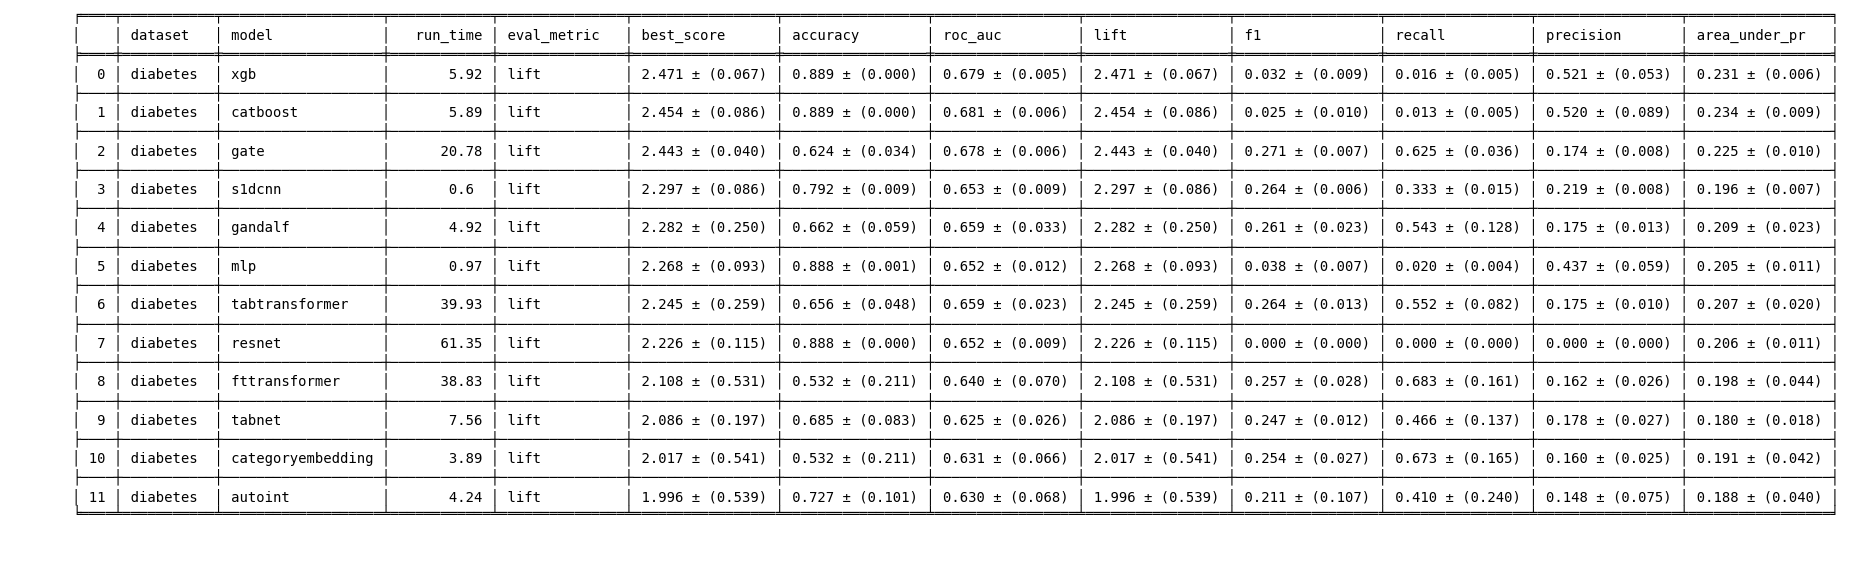

In [20]:
display_cols = ['dataset', 'model', 'run_time', 'eval_metric', 'best_score', 'accuracy','roc_auc', 'lift', 
                'f1','recall', 'precision', 'area_under_pr']
metric_cols = ['accuracy','roc_auc', 'lift', 
                'f1','recall', 'precision', 'area_under_pr']
dataset_name = "diabetes"
make_results_table(best_df, dataset_name, display_cols, metric_cols, image_name = dataset_name, dpi = 1200)

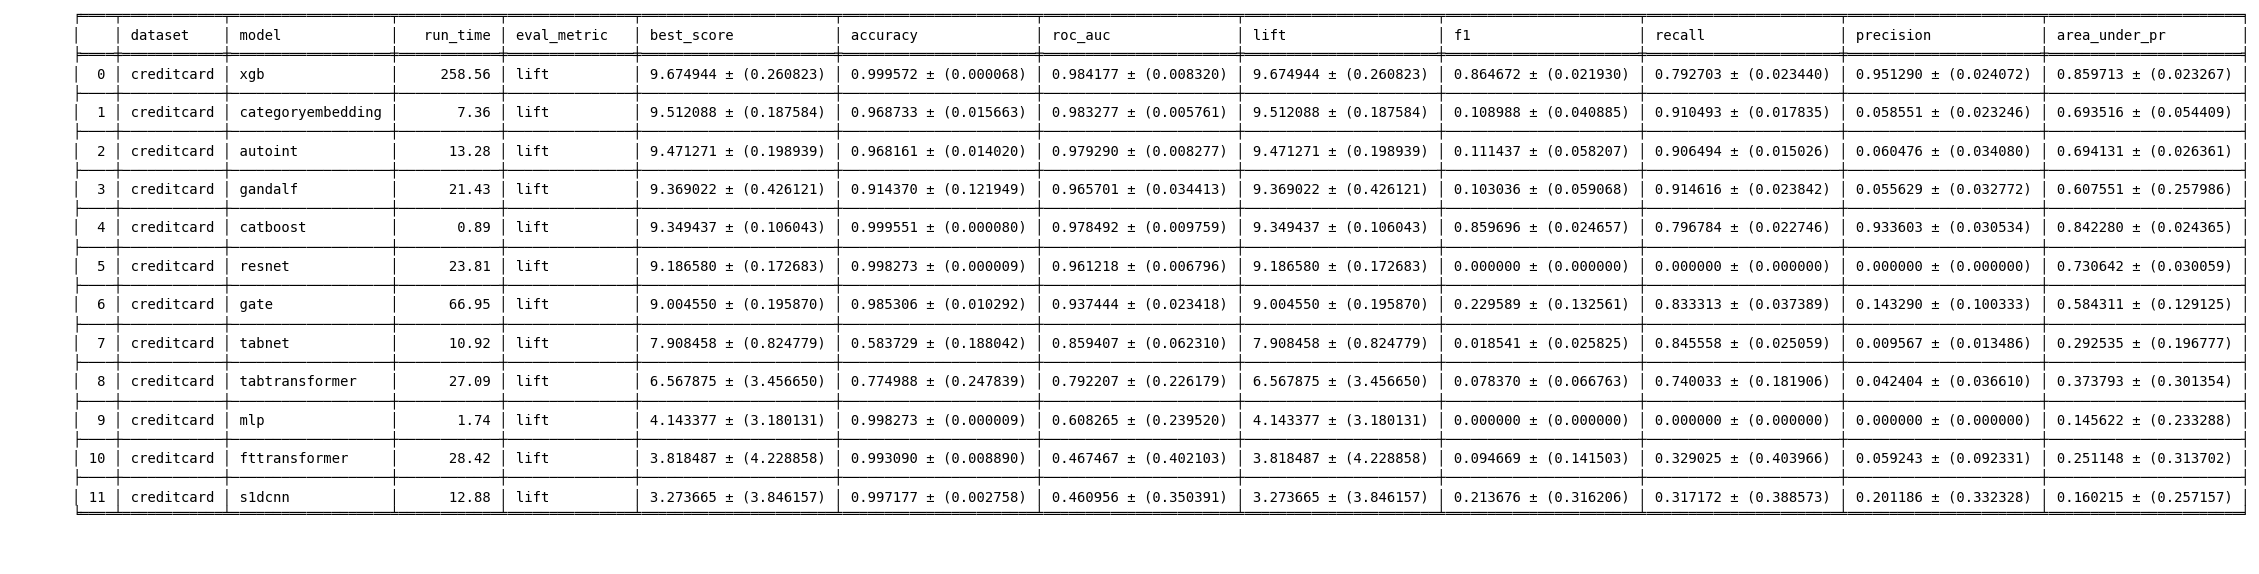

,dataset,model,run_time,eval_metric,best_score,accuracy,roc_auc,lift,f1,recall,precision,area_under_pr
0,creditcard,xgb,258.56,lift,9.674944 ± (0.260823),0.999572 ± (0.000068),0.984177 ± (0.008320),9.674944 ± (0.260823),0.864672 ± (0.021930),0.792703 ± (0.023440),0.951290 ± (0.024072),0.859713 ± (0.023267)
1,creditcard,categoryembedding,7.36,lift,9.512088 ± (0.187584),0.968733 ± (0.015663),0.983277 ± (0.005761),9.512088 ± (0.187584),0.108988 ± (0.040885),0.910493 ± (0.017835),0.058551 ± (0.023246),0.693516 ± (0.054409)
2,creditcard,autoint,13.28,lift,9.471271 ± (0.198939),0.968161 ± (0.014020),0.979290 ± (0.008277),9.471271 ± (0.198939),0.111437 ± (0.058207),0.906494 ± (0.015026),0.060476 ± (0.034080),0.694131 ± (0.026361)
3,creditcard,gandalf,21.43,lift,9.369022 ± (0.426121),0.914370 ± (0.121949),0.965701 ± (0.034413),9.369022 ± (0.426121),0.103036 ± (0.059068),0.914616 ± (0.023842),0.055629 ± (0.032772),0.607551 ± (0.257986)
4,creditcard,catboost,0.89,lift,9.349437 ± (0.106043),0.999551 ± (0.000080),0.978492 ± (0.009759),9.349437 ± (0.106043),0.859696 ± (0.024657),0.796784 ± (0.022746),0.933603 ± (0.030534),0.842280 ± (0.024365)
5,creditcard,resnet,23.81,lift,9.186580 ± (0.172683),0.998273 ± (0.000009),0.961218 ± (0.006796),9.186580 ± (0.172683),0.000000 ± (0.000000),0.000000 ± (0.000000),0.000000 ± (0.000000),0.730642 ± (0.030059)
6,creditcard,gate,66.95,lift,9.004550 ± (0.195870),0.985306 ± (0.010292),0.937444 ± (0.023418),9.004550 ± (0.195870),0.229589 ± (0.132561),0.833313 ± (0.037389),0.143290 ± (0.100333),0.584311 ± (0.129125)
7,creditcard,tabnet,10.92,lift,7.908458 ± (0.824779),0.583729 ± (0.188042),0.859407 ± (0.062310),7.908458 ± (0.824779),0.018541 ± (0.025825),0.845558 ± (0.025059),0.009567 ± (0.013486),0.292535 ± (0.196777)
8,creditcard,tabtransformer,27.09,lift,6.567875 ± (3.456650),0.774988 ± (0.247839),0.792207 ± (0.226179),6.567875 ± (3.456650),0.078370 ± (0.066763),0.740033 ± (0.181906),0.042404 ± (0.036610),0.373793 ± (0.301354)
9,creditcard,mlp,1.74,lift,4.143377 ± (3.180131),0.998273 ± (0.000009),0.608265 ± (0.239520),4.143377 ± (3.180131),0.000000 ± (0.000000),0.000000 ± (0.000000),0.000000 ± (0.000000),0.145622 ± (0.233288)


In [14]:
display_cols = ['dataset', 'model', 'run_time', 'eval_metric', 'best_score', 'accuracy','roc_auc', 'lift', 
                'f1','recall', 'precision', 'area_under_pr']
metric_cols = ['accuracy','roc_auc', 'lift', 
                'f1','recall', 'precision', 'area_under_pr']
dataset_name = "creditcard"
make_results_table(best_df, dataset_name, display_cols, metric_cols, image_name = dataset_name, dpi = 1200)

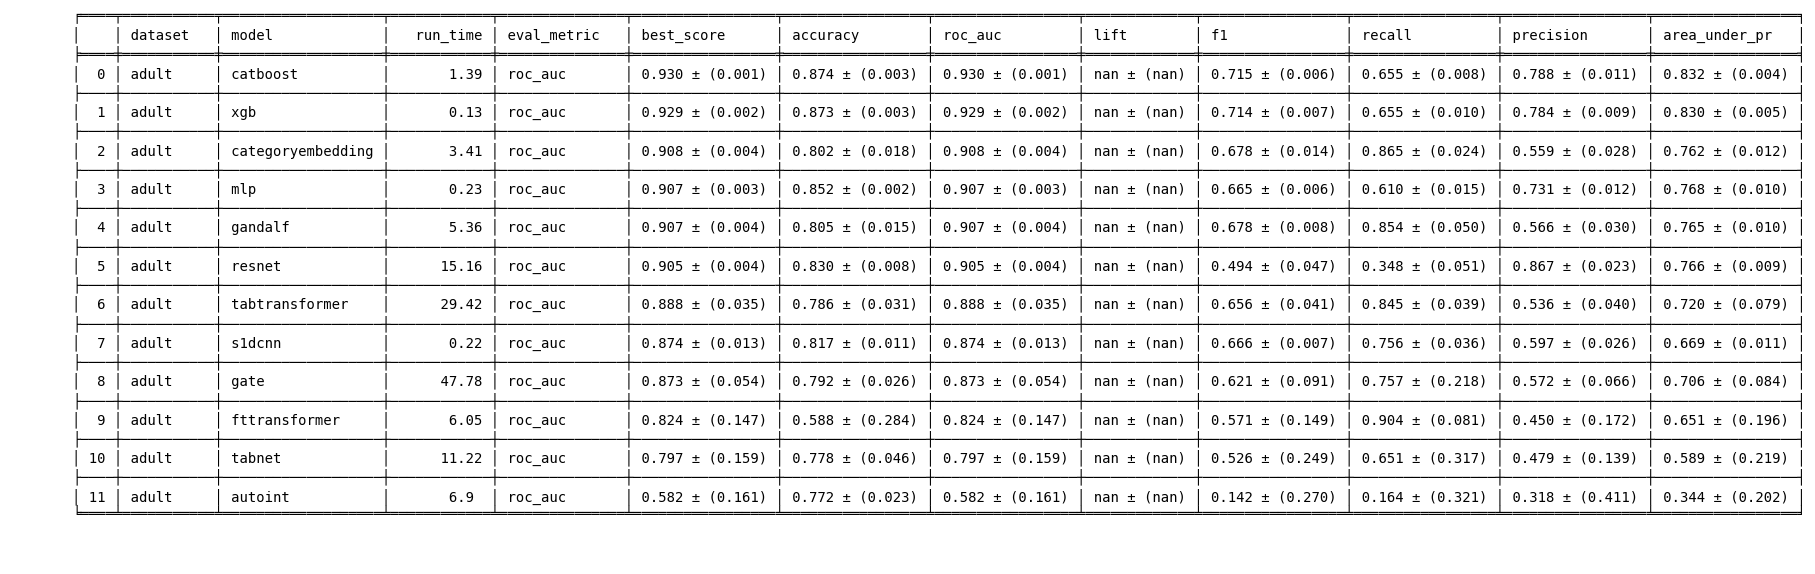

In [22]:
display_cols = ['dataset', 'model', 'run_time', 'eval_metric', 'best_score', 'accuracy','roc_auc', 'lift', 
                'f1','recall', 'precision', 'area_under_pr']
metric_cols = ['accuracy','roc_auc', 'lift', 
                'f1','recall', 'precision', 'area_under_pr']
dataset_name = "adult"
make_results_table(best_df, dataset_name, display_cols, metric_cols, image_name = dataset_name, dpi = 1200)

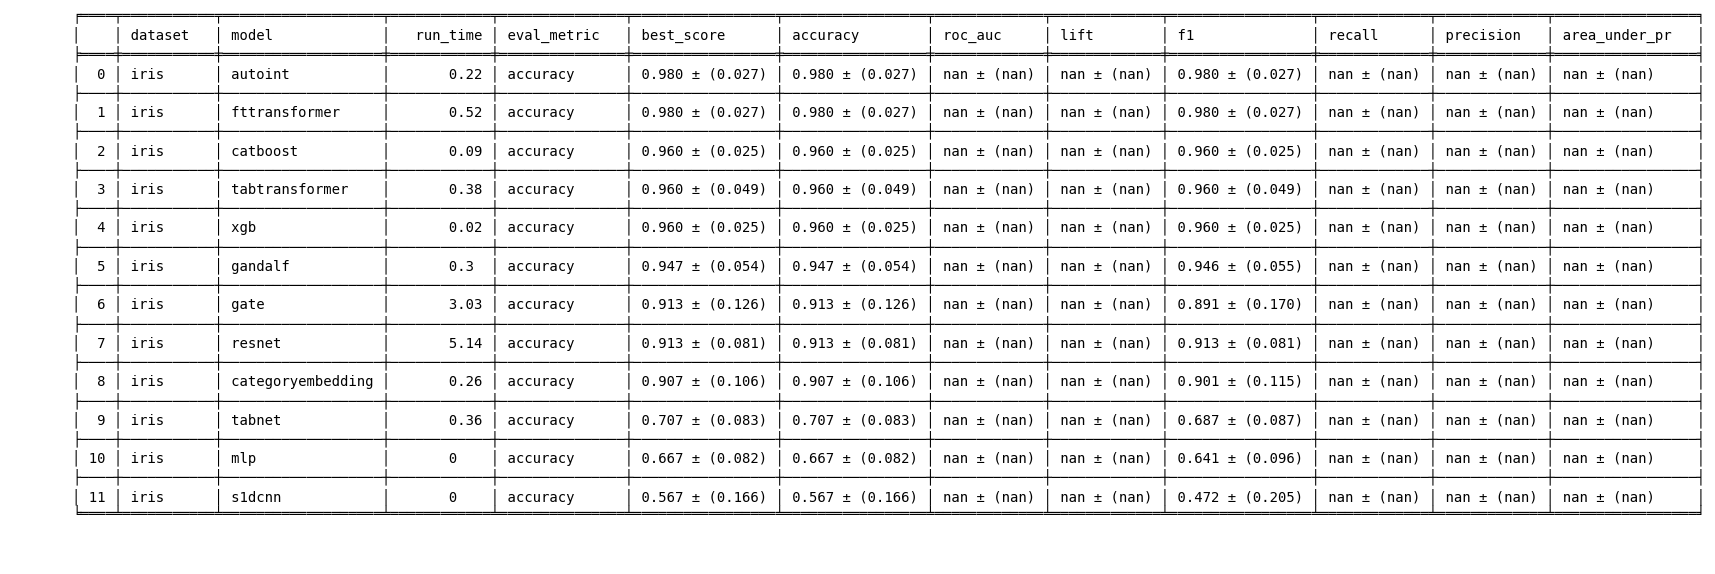

In [23]:
display_cols = ['dataset', 'model', 'run_time', 'eval_metric', 'best_score', 'accuracy','roc_auc', 'lift', 
                'f1','recall', 'precision', 'area_under_pr']
metric_cols = ['accuracy','roc_auc', 'lift', 
                'f1','recall', 'precision', 'area_under_pr']
dataset_name = "iris"
make_results_table(best_df, dataset_name, display_cols, metric_cols, image_name = dataset_name, dpi = 1200)

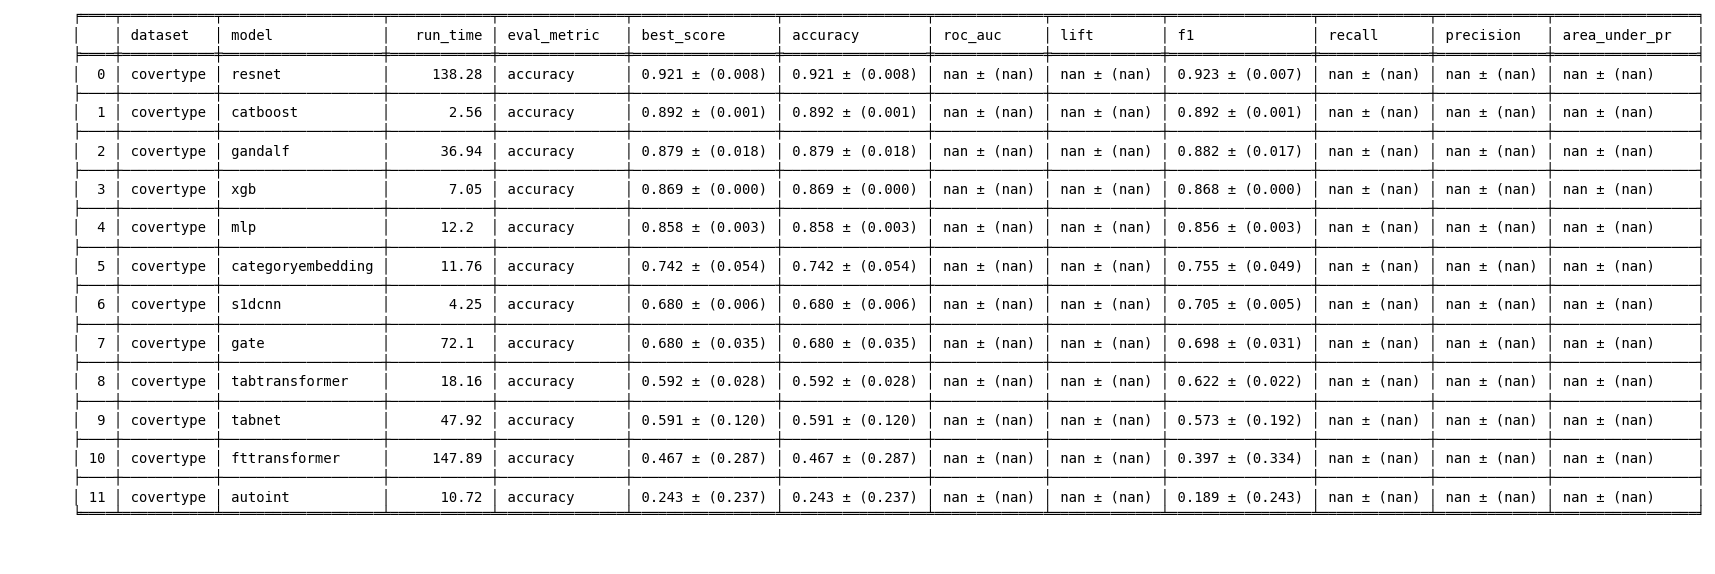

In [24]:
display_cols = ['dataset', 'model', 'run_time', 'eval_metric', 'best_score', 'accuracy','roc_auc', 'lift', 
                'f1','recall', 'precision', 'area_under_pr']
metric_cols = ['accuracy','roc_auc', 'lift', 
                'f1','recall', 'precision', 'area_under_pr']
dataset_name = "covertype"
make_results_table(best_df, dataset_name, display_cols, metric_cols, image_name = dataset_name, dpi = 1200)

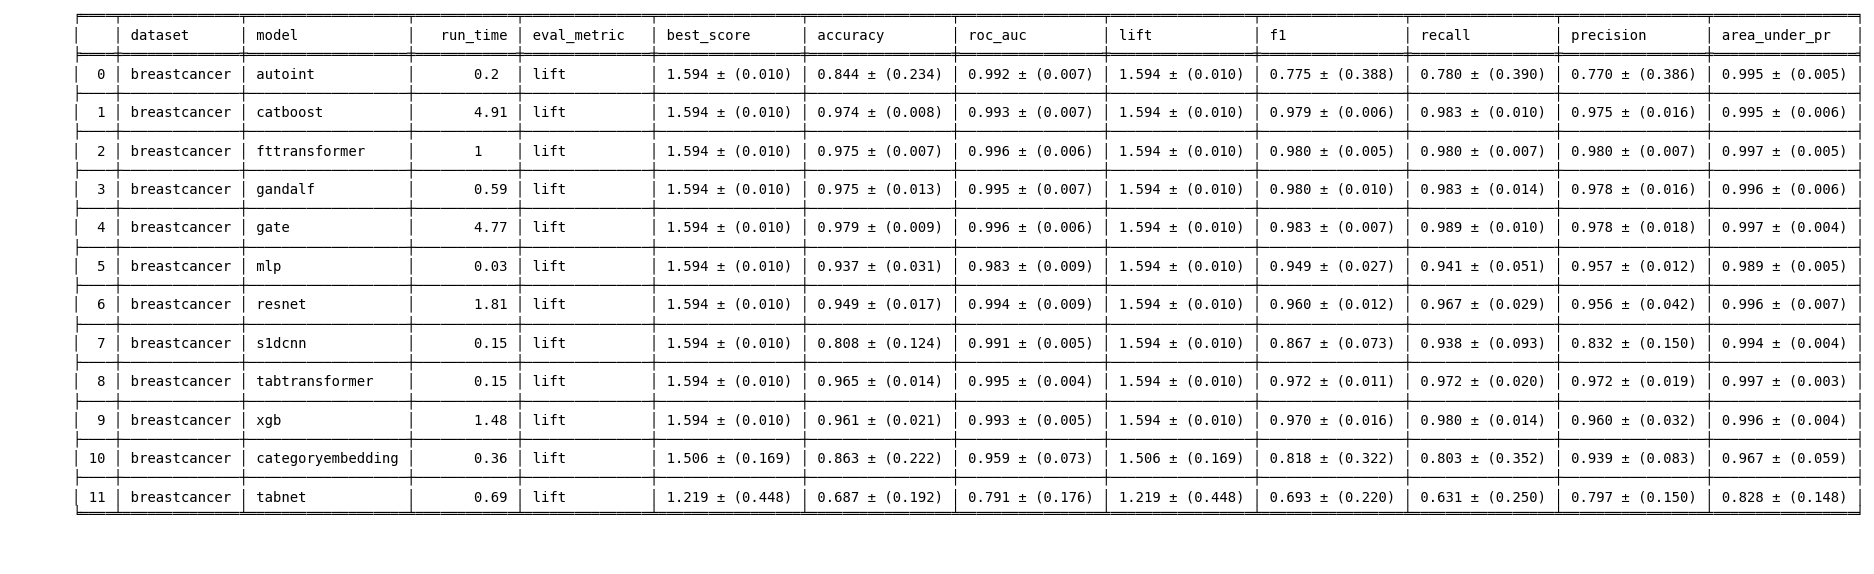

In [25]:
display_cols = ['dataset', 'model', 'run_time', 'eval_metric', 'best_score', 'accuracy','roc_auc', 'lift', 
                'f1','recall', 'precision', 'area_under_pr']
metric_cols = ['accuracy','roc_auc', 'lift', 
                'f1','recall', 'precision', 'area_under_pr']
dataset_name = "breastcancer"
make_results_table(best_df, dataset_name, display_cols, metric_cols, image_name = dataset_name, dpi = 1200)

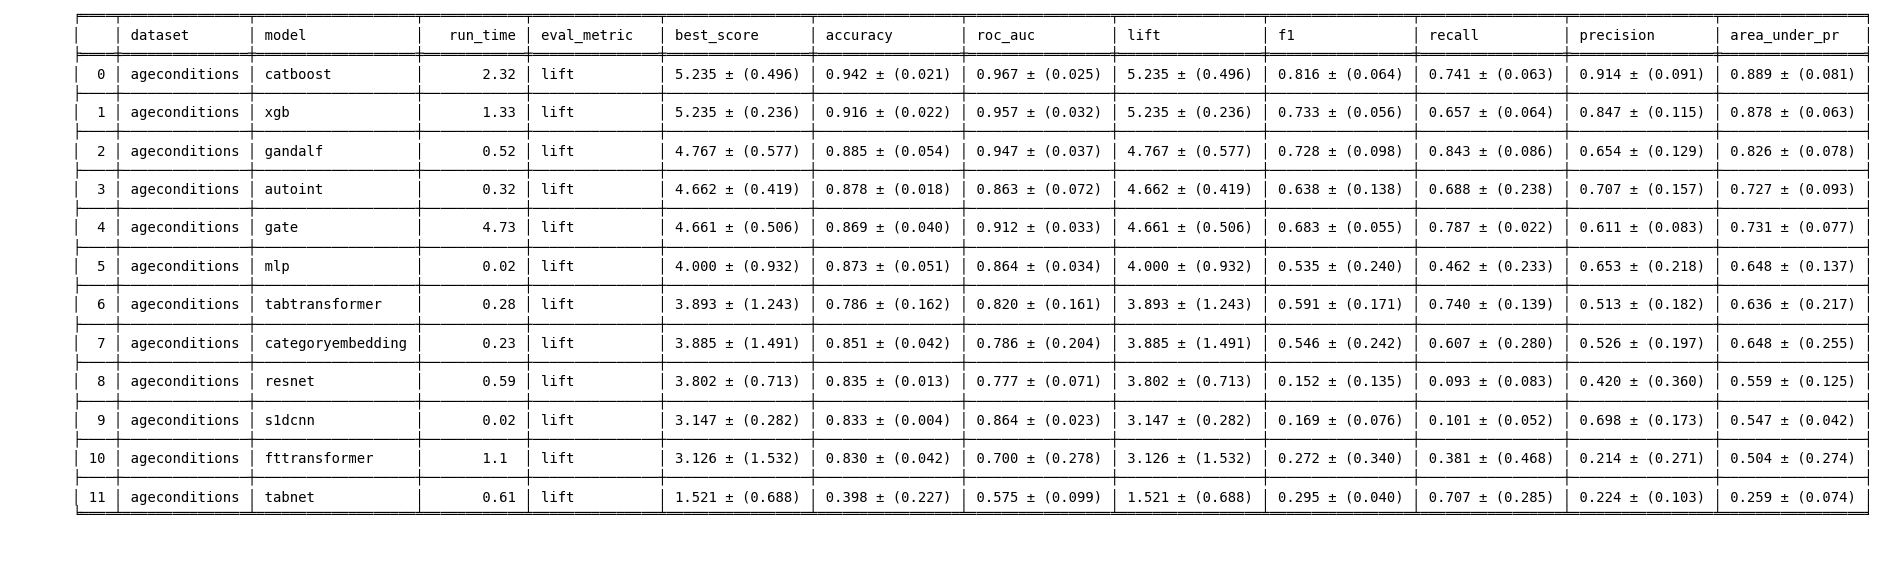

In [26]:
display_cols = ['dataset', 'model', 'run_time', 'eval_metric', 'best_score', 'accuracy','roc_auc', 'lift', 
                'f1','recall', 'precision', 'area_under_pr']
metric_cols = ['accuracy','roc_auc', 'lift', 
                'f1','recall', 'precision', 'area_under_pr']
dataset_name = "ageconditions"
make_results_table(best_df, dataset_name, display_cols, metric_cols, image_name = dataset_name, dpi = 1200)